In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm

# 1. Constants & Setup

HIDDEN_SIZE = 768
PERSONALITY_SIZE = 5
MOOD_SIZE = 3
SEQ_LEN = 3
EMOTION_LABELS = ['neutral', 'joy', 'sadness', 'anger', 'fear', 'disgust', 'surprise']

# 2. Dataset

class DyadicPELDataset(Dataset):
    def __init__(self, filepath):
        self.data = pd.read_csv(filepath, sep='\t')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.label2idx = {e: i for i, e in enumerate(EMOTION_LABELS)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        utterances = [row['Utterance_1'], row['Utterance_2'], row['Utterance_3']]
        encoded = self.tokenizer(utterances, return_tensors='pt', padding='max_length', truncation=True, max_length=64)

        personality = eval(row['Personality'])
        personality = torch.tensor(personality, dtype=torch.float32)

        label = self.label2idx.get(row['Emotion_3'], 0)
        return encoded['input_ids'], encoded['attention_mask'], personality, torch.tensor(label)


# 3. Utility: Personality → Mood

def personality_to_vad(personality):
    O, C, E, A, N = personality[:,0], personality[:,1], personality[:,2], personality[:,3], personality[:,4]
    P_V = 0.21 * E + 0.59 * A + 0.19 * N
    P_A = 0.15 * O + 0.30 * A - 0.57 * N
    P_D = 0.25 * O + 0.17 * C + 0.60 * E - 0.32 * A
    return torch.stack([P_V, P_A, P_D], dim=1)

In [ ]:
# 4. TCN Architecture

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, 1, dilation, (kernel_size - 1) * dilation, dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):  # (B, D, T)
        return self.network(x)

In [ ]:
# 5. Emotion Prediction

class EmotionPredictor(nn.Module):
    def __init__(self, num_emotions):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.tcn = TCN(HIDDEN_SIZE, [HIDDEN_SIZE]*2)

        self.mood_shift = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + PERSONALITY_SIZE + MOOD_SIZE, 64),
            nn.ReLU(),
            nn.Linear(64, MOOD_SIZE)
        )

        self.emotion_head = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + PERSONALITY_SIZE + MOOD_SIZE, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_emotions)
        )

    def forward(self, input_ids, attention_mask, personality):
        B, T, L = input_ids.shape
        utterances = []
        for t in range(T):
            out = self.bert(input_ids[:,t], attention_mask=attention_mask[:,t])
            cls = out.last_hidden_state[:, 0, :]
            utterances.append(cls)
        x = torch.stack(utterances, dim=2)  # (B, D, T)
        context = self.tcn(x)[:, :, -1]     # final time step
        mood_0 = personality_to_vad(personality)
        delta = self.mood_shift(torch.cat([context, personality, mood_0], dim=1))
        mood = mood_0 + delta
        logits = self.emotion_head(torch.cat([context, personality, mood], dim=1))
        return logits, mood

In [ ]:
# 6. Training & Evaluation Loop

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for i, (input_ids, attn_mask, personality, labels) in enumerate(dataloader):
        input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
        personality, labels = personality.to(device), labels.to(device)

        logits, _ = model(input_ids, attn_mask, personality)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"  Step {i+1}/{len(dataloader)} - Loss: {loss.item():.4f}")
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attn_mask, personality, labels in dataloader:
            input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
            personality, labels = personality.to(device), labels.to(device)
            logits, _ = model(input_ids, attn_mask, personality)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [ ]:
def calculate_loss(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for input_ids, attn_mask, personality, labels in dataloader:
            input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
            personality, labels = personality.to(device), labels.to(device)
            logits, _ = model(input_ids, attn_mask, personality)
            loss = criterion(logits, labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
# if __name__ == '__main__':
#     import argparse
#     from sklearn.metrics import classification_report, f1_score
#     from torch.utils.data import random_split

#     parser = argparse.ArgumentParser()
#     parser.add_argument('--data', type=str, default='Dyadic_PELD_1.tsv')
#     parser.add_argument('--epochs', type=int, default=5)
#     parser.add_argument('--batch_size', type=int, default=16)
#     parser.add_argument('--lr', type=float, default=2e-5)
#     args = parser.parse_args(args=[])

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     dataset = DyadicPELDataset(args.data)

#     # Split: 80% train, 10% val, 10% test
#     total_len = len(dataset)
#     train_len = int(0.8 * total_len)
#     val_len = int(0.1 * total_len)
#     test_len = total_len - train_len - val_len
#     train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

#     train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
#     val_loader = DataLoader(val_set, batch_size=args.batch_size)
#     test_loader = DataLoader(test_set, batch_size=args.batch_size)

#     model = EmotionPredictor(num_emotions=len(EMOTION_LABELS)).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
#     criterion = nn.CrossEntropyLoss()

#     # Train model (only show train loss)
#     for epoch in range(args.epochs):
#         print(f"\nEpoch {epoch+1}/{args.epochs}")
#         train_loss = train(model, train_loader, optimizer, criterion, device)
#         print(f"Train Loss: {train_loss:.4f}")

#     # 🔍 Final benchmark on test set
#     print("\n✅ Final Test Set Results:")
#     y_true, y_pred = evaluate(model, test_loader, device)
#     print(classification_report(y_true, y_pred, target_names=EMOTION_LABELS))
#     print("Weighted F1-score:", f1_score(y_true, y_pred, average='weighted'))
#     print("Macro F1-score:", f1_score(y_true, y_pred, average='macro'))

if __name__ == '__main__':
    import argparse
    from sklearn.metrics import classification_report, f1_score
    from torch.utils.data import random_split
    from sklearn.model_selection import train_test_split
    from torch.utils.data import Subset

    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default='Dyadic_PELD_1.tsv')
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--lr', type=float, default=2e-5)
    args = parser.parse_args(args=[])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = DyadicPELDataset(args.data)

    # Split: 80% train, 10% val, 10% test
    # total_len = len(dataset)
    # train_len = int(0.8 * total_len)
    # val_len = int(0.1 * total_len)
    # test_len = total_len - train_len - val_len
    # train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    # Extract labels from dataset
    all_labels = [example[3].item() for example in dataset]  # example = (input_ids, attn_mask, personality, label)

    # Step 1: Train vs Temp (Val + Test)
    train_indices, temp_indices = train_test_split(
        list(range(len(dataset))),
        test_size=0.2,
        stratify=all_labels,
        random_state=42
    )

    # Step 2: Temp → Val and Test
    temp_labels = [all_labels[i] for i in temp_indices]
    val_indices, test_indices = train_test_split(
        temp_indices,
        test_size=0.5,
        stratify=temp_labels,
        random_state=42
    )

    # Create subsets
    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    test_set = Subset(dataset, test_indices)

    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=args.batch_size)
    test_loader = DataLoader(test_set, batch_size=args.batch_size)

    model = EmotionPredictor(num_emotions=len(EMOTION_LABELS)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    criterion = FocalLoss(alpha=1.0, gamma=2.0)

    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 0
    counter = 0

    # Train model (only show train loss)

    for epoch in range(args.epochs):
      print(f"\nEpoch {epoch+1}/{args.epochs}")
      train_loss = train(model, train_loader, optimizer, criterion, device)
      test_loss = calculate_loss(model, test_loader, criterion, device)

      print(f"Train Loss: {train_loss:.4f}")

      train_losses.append(train_loss)
      test_losses.append(test_loss)

      # Early Stopping Check
      if test_loss < best_test_loss:
        best_test_loss = test_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
      else:
        counter += 1
        print(f"No improvement. Early stop patience {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # 🔍 Final benchmark on test set
    model.load_state_dict(torch.load("best_model.pt"))
    print("\nEvaluation results:")
    y_true, y_pred = evaluate(model, test_loader, device)
    print(classification_report(y_true, y_pred, target_names=EMOTION_LABELS))
    print("Weighted F1-score:", f1_score(y_true, y_pred, average='weighted'))
    print("Macro F1-score:", f1_score(y_true, y_pred, average='macro'))


Epoch 1/5
  Step 1/326 - Loss: 1.9250
  Step 11/326 - Loss: 1.9747
  Step 21/326 - Loss: 1.5490
  Step 31/326 - Loss: 1.5667
  Step 41/326 - Loss: 1.5925
  Step 51/326 - Loss: 1.8768
  Step 61/326 - Loss: 1.6708
  Step 71/326 - Loss: 1.2934
  Step 81/326 - Loss: 1.5722
  Step 91/326 - Loss: 1.4886
  Step 101/326 - Loss: 1.6743
  Step 111/326 - Loss: 1.3721
  Step 121/326 - Loss: 1.3226
  Step 131/326 - Loss: 1.5980
  Step 141/326 - Loss: 1.7695
  Step 151/326 - Loss: 1.4115
  Step 161/326 - Loss: 1.5008
  Step 171/326 - Loss: 1.4594
  Step 181/326 - Loss: 1.6897
  Step 191/326 - Loss: 1.3252
  Step 201/326 - Loss: 1.4590
  Step 211/326 - Loss: 1.7529
  Step 221/326 - Loss: 1.4700
  Step 231/326 - Loss: 1.6671
  Step 241/326 - Loss: 0.7231
  Step 251/326 - Loss: 1.3047
  Step 261/326 - Loss: 1.2626
  Step 271/326 - Loss: 1.5233
  Step 281/326 - Loss: 1.1023
  Step 291/326 - Loss: 1.2847
  Step 301/326 - Loss: 1.1673
  Step 311/326 - Loss: 1.4618
  Step 321/326 - Loss: 1.2935
Train Loss

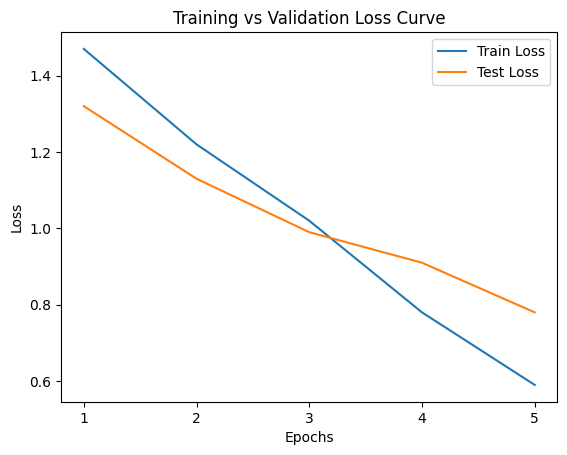

In [18]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses)+1))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(False)
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [ ]:
if __name__ == '__main__':
    import argparse
    from sklearn.metrics import classification_report, f1_score
    from sklearn.model_selection import train_test_split
    from torch.utils.data import Subset
    import numpy as np

    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default='Dyadic_PELD_1.tsv')
    parser.add_argument('--epochs', type=int, default=5)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--lr', type=float, default=2e-5)
    args = parser.parse_args(args=[])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = DyadicPELDataset(args.data)

    # Step 1: Extract all emotion labels (needed for stratification)
    all_labels = [dataset[i][-1] for i in range(len(dataset))]

    # Step 2: Stratified split → train (80%) and temp (20%)
    indices = np.arange(len(dataset))
    train_idx, temp_idx = train_test_split(
        indices,
        test_size=0.2,
        stratify=all_labels,
        random_state=42
    )

    # Step 3: Stratify temp into val (10%) and test (10%)
    temp_labels = [all_labels[i] for i in temp_idx]
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=temp_labels,
        random_state=42
    )

    # Step 4: Create dataset subsets
    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)

    # Step 5: Dataloaders
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=args.batch_size)
    test_loader = DataLoader(test_set, batch_size=args.batch_size)

    # Step 6: Model & Training
    model = EmotionPredictor(num_emotions=len(EMOTION_LABELS)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    criterion = FocalLoss(gamma=2.0)

    for epoch in range(args.epochs):
        print(f"\nEpoch {epoch+1}/{args.epochs}")
        train_loss = train(model, train_loader, optimizer, criterion, device)
        print(f"Train Loss: {train_loss:.4f}")

    # Step 7: Evaluation
    print("\n Evaluation:")
    y_true, y_pred = evaluate(model, test_loader, device)
    print(classification_report(y_true, y_pred, target_names=EMOTION_LABELS))
    print("Weighted F1-score:", f1_score(y_true, y_pred, average='weighted'))
    print("Macro F1-score:", f1_score(y_true, y_pred, average='macro'))


Epoch 1/5
  Step 1/326 - Loss: 1.4451
  Step 11/326 - Loss: 1.2383
  Step 21/326 - Loss: 1.2256
  Step 31/326 - Loss: 1.3234
  Step 41/326 - Loss: 1.1232
  Step 51/326 - Loss: 1.2692
  Step 61/326 - Loss: 1.1218
  Step 71/326 - Loss: 0.8076
  Step 81/326 - Loss: 1.1902
  Step 91/326 - Loss: 1.0998
  Step 101/326 - Loss: 1.1575
  Step 111/326 - Loss: 0.9811
  Step 121/326 - Loss: 1.0937
  Step 131/326 - Loss: 1.0239
  Step 141/326 - Loss: 0.7524
  Step 151/326 - Loss: 0.8560
  Step 161/326 - Loss: 1.1908
  Step 171/326 - Loss: 0.8554
  Step 181/326 - Loss: 1.2152
  Step 191/326 - Loss: 0.8040
  Step 201/326 - Loss: 0.9189
  Step 211/326 - Loss: 0.6591
  Step 221/326 - Loss: 0.8526
  Step 231/326 - Loss: 1.2382
  Step 241/326 - Loss: 0.8243
  Step 251/326 - Loss: 0.6385
  Step 261/326 - Loss: 0.9983
  Step 271/326 - Loss: 0.6618
  Step 281/326 - Loss: 0.9625
  Step 291/326 - Loss: 0.7708
  Step 301/326 - Loss: 0.7168
  Step 311/326 - Loss: 1.0219
  Step 321/326 - Loss: 0.7502
Train Loss

In [ ]:
# 6. Training & Evaluation Loop

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for i, (input_ids, attn_mask, personality, labels) in enumerate(dataloader):
        input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
        personality, labels = personality.to(device), labels.to(device)

        logits, _ = model(input_ids, attn_mask, personality)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"  Step {i+1}/{len(dataloader)} - Loss: {loss.item():.4f}")
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attn_mask, personality, labels in dataloader:
            input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
            personality, labels = personality.to(device), labels.to(device)
            logits, _ = model(input_ids, attn_mask, personality)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
if __name__ == '__main__':
    import argparse
    from sklearn.metrics import classification_report, f1_score
    from torch.utils.data import random_split

    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default='Dyadic_PELD_1.tsv')
    parser.add_argument('--epochs', type=int, default=2)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--lr', type=float, default=2e-5)
    args = parser.parse_args(args=[])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = DyadicPELDataset(args.data)

    # Split: 80% train, 10% val, 10% test
    total_len = len(dataset)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len
    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=args.batch_size)
    test_loader = DataLoader(test_set, batch_size=args.batch_size)

    model = EmotionPredictor(num_emotions=len(EMOTION_LABELS)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    criterion = FocalLoss(alpha=1.0, gamma=2.0)

    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience = 1
    counter = 0

    # Train model (only show train loss)

    for epoch in range(args.epochs):
      print(f"\nEpoch {epoch+1}/{args.epochs}")
      train_loss = train(model, train_loader, optimizer, criterion, device)
      test_loss = calculate_loss(model, test_loader, criterion, device)

      print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

      train_losses.append(train_loss)
      test_losses.append(test_loss)

      # Early Stopping Check
      if test_loss < best_test_loss:
        best_test_loss = test_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
      else:
        counter += 1
        print(f"No improvement. Early stop patience {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # 🔍 Final benchmark on test set
    model.load_state_dict(torch.load("best_model.pt"))
    print("\nEvaluation results:")
    y_true, y_pred = evaluate(model, test_loader, device)
    print(classification_report(y_true, y_pred, target_names=EMOTION_LABELS))
    print("Weighted F1-score:", f1_score(y_true, y_pred, average='weighted'))
    print("Macro F1-score:", f1_score(y_true, y_pred, average='macro'))


Epoch 1/2
  Step 1/326 - Loss: 1.9225
  Step 11/326 - Loss: 1.7897
  Step 21/326 - Loss: 1.9100
  Step 31/326 - Loss: 1.7118
  Step 41/326 - Loss: 1.5702
  Step 51/326 - Loss: 1.6670
  Step 61/326 - Loss: 1.4653
  Step 71/326 - Loss: 1.6172
  Step 81/326 - Loss: 1.3790
  Step 91/326 - Loss: 1.6059
  Step 101/326 - Loss: 1.3847
  Step 111/326 - Loss: 1.4341
  Step 121/326 - Loss: 1.7757
  Step 131/326 - Loss: 1.4087
  Step 141/326 - Loss: 1.9114
  Step 151/326 - Loss: 1.9295
  Step 161/326 - Loss: 1.2953
  Step 171/326 - Loss: 1.4735
  Step 181/326 - Loss: 1.2743
  Step 191/326 - Loss: 1.4362
  Step 201/326 - Loss: 1.1989
  Step 211/326 - Loss: 1.7717
  Step 221/326 - Loss: 1.6318
  Step 231/326 - Loss: 1.1129
  Step 241/326 - Loss: 1.8090
  Step 251/326 - Loss: 1.7006
  Step 261/326 - Loss: 1.5144
  Step 271/326 - Loss: 1.5366
  Step 281/326 - Loss: 1.8263
  Step 291/326 - Loss: 1.5353
  Step 301/326 - Loss: 1.3508
  Step 311/326 - Loss: 1.4045
  Step 321/326 - Loss: 1.4747
Train Loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
